dict_keys(['50per_Ring1.5-5', 'Body', 'Body_Ring0-3', 'BrachialPlexus', 'CTV', 'Esophagus', 'GTV', 'GreatVessels', 'Heart', 'LAD', 'Lung_Cntr', 'Lung_Ipsi', 'Lung_Total', 'PTV', 'PTV_Ring.3-2', 'SpinalCord', 'SpinalCord_05', 'Total Lung-GTV', 'Trachea', 'all_mask', 'img', 'dose', 'dose_scale', 'isVMAT', 'isocenter', 'angle_list', 'origin', 'spacing', 'direction', 'size', 'angle_plate', 'beam_plate'])


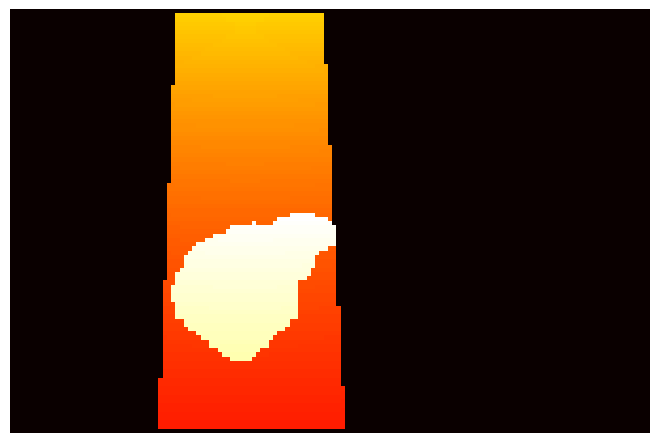

In [3]:
%run generate_geometry.py

In [9]:
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode as intpl

In [10]:
img = torch.from_numpy(d.PTV[48]).unsqueeze(0)

In [11]:
img.shape

torch.Size([1, 100, 151])

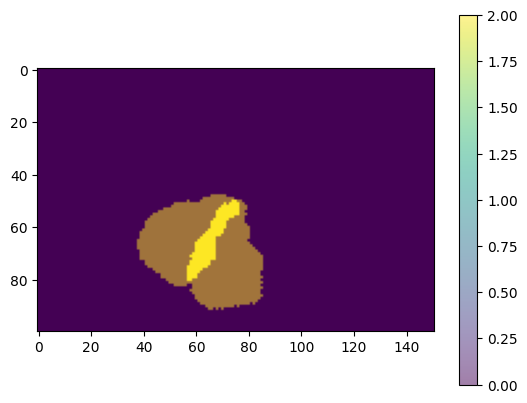

In [12]:
# Default rotation is around the centre
img_r = rotate(img, 45)

plt.imshow(img_r.squeeze())
plt.imshow(img.squeeze()*2, alpha=0.5)
plt.colorbar()

In [13]:
d.isocenter

[np.float64(48.0), np.float64(64.0), np.float64(55.0)]

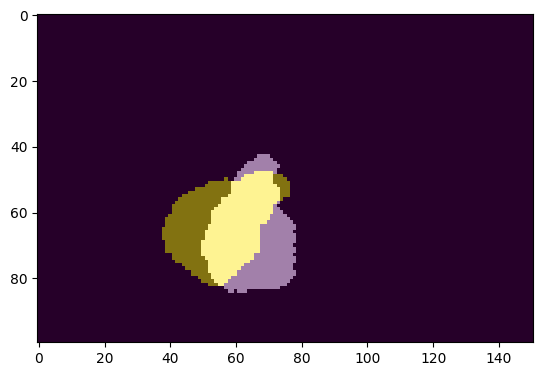

In [14]:
# Interpolation: InterpolationMode.NEAREST, InterpolationMode.BILINEAR
# default: nearest
img_r = rotate(img, 45, center=(64,55), interpolation=intpl.BILINEAR)

plt.imshow(img_r.squeeze(), cmap='hot')
plt.imshow(img.squeeze(), alpha=0.5)

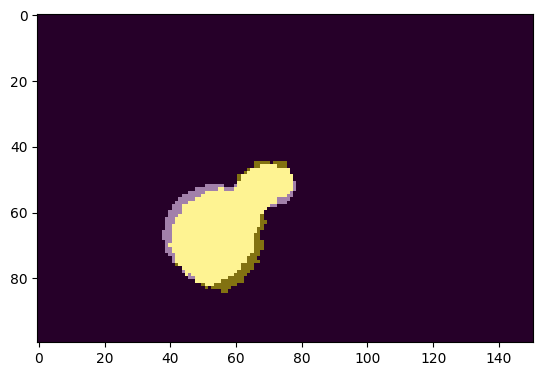

In [15]:
# Multiple slices

ptv = torch.tensor(d.PTV)

ptv_r = rotate(ptv, 10, center=d.isocenter[1:])

plt.imshow(ptv[40], cmap='hot')
plt.imshow(ptv_r[40], alpha=0.5)

In [9]:
d.angle_list

array([  0., 160., 280., 320.,  40., 200.,  80., 240., 120.],
      dtype=float32)

In [20]:
d.angle_list[:3]

array([  0., 160., 280.], dtype=float32)

In [25]:
d.angle_list[:1]

array([0.], dtype=float32)

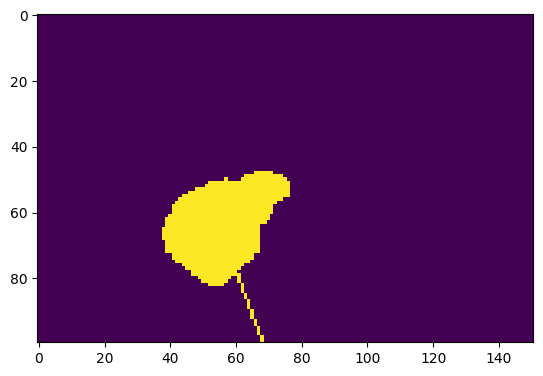

In [16]:
angle_plate = PlotGantry(
            bg_img = d.PTV[48],
            angles = d.angle_list[1:2],
            x = int(d.isocenter[2]),
            y = int(d.isocenter[1]),
            length =  50,
            width = 1)

plt.imshow(angle_plate)

In [64]:
d.isocenter

[np.float64(48.0), np.float64(64.0), np.float64(55.0)]

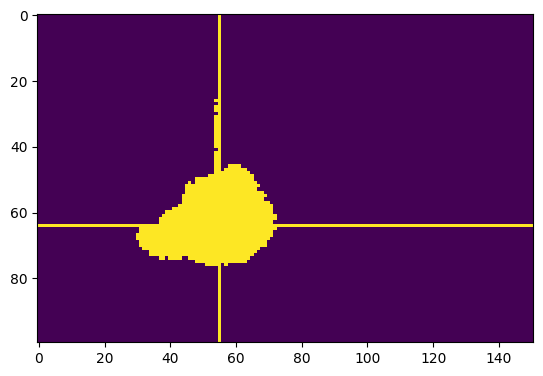

In [80]:
temp = rotate(torch.from_numpy(angle_plate).unsqueeze(0), 160, center=(55, 64))[0]
temp[64,:] = 1
temp[:, 55] = 1
plt.imshow(temp)

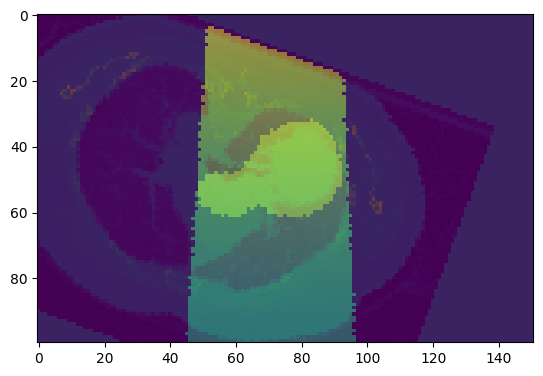

In [46]:
# Multiple slices

beam_plate2 = get_per_beamplate(
    PTV_mask = d['PTV'].copy(),
    isocenter = d['isocenter'],
    space = [2, 2.5, 2.5],
    gantry_angle = d['angle_list'][1],
    with_distance = True
  ).astype('float')
beam_plate2 = torch.from_numpy(beam_plate2)

ptv = torch.tensor(d.PTV)
ct = torch.tensor(d.img)

ptv_r = rotate(ptv, 160, center=d.isocenter[1:])
beam_plate2_r = rotate(beam_plate2, 160, center=d.isocenter[1:])
ct_r = rotate(ct, 160, center=d.isocenter[1:])


# plt.imshow(ptv[40], cmap='hot')
plt.imshow(ct_r[40])
plt.imshow(ptv_r[40], alpha=0.5)
plt.imshow(beam_plate2_r[40], alpha=0.5)

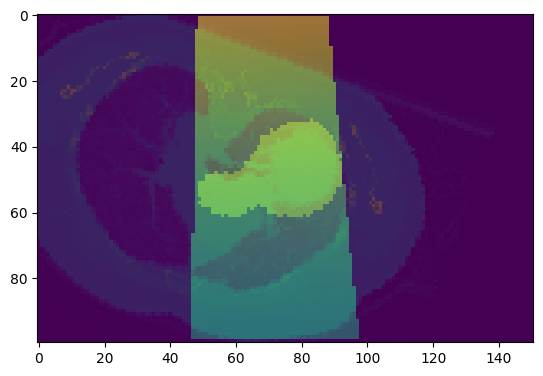

In [47]:
# The previous beam plate can be generated from 0 degree after rotation

ptv = torch.tensor(d.PTV)
ct = torch.tensor(d.img)

ptv_r = rotate(ptv, 160, center=d.isocenter[1:])
ct_r = rotate(ct, 160, center=d.isocenter[1:], fill=-1024) # Notice the CT background is not 0

# Generate the beam plate
beam_plate2_gen = get_per_beamplate(
    PTV_mask = ptv_r.numpy().copy(),
    isocenter = d['isocenter'],
    space = [2, 2.5, 2.5],
    gantry_angle = 0,
    with_distance = True
  ).astype('float')


# plt.imshow(ptv[40], cmap='hot')
plt.imshow(ct_r[40])
plt.imshow(ptv_r[40], alpha=0.5)
plt.imshow(beam_plate2_gen[40], alpha=0.5)

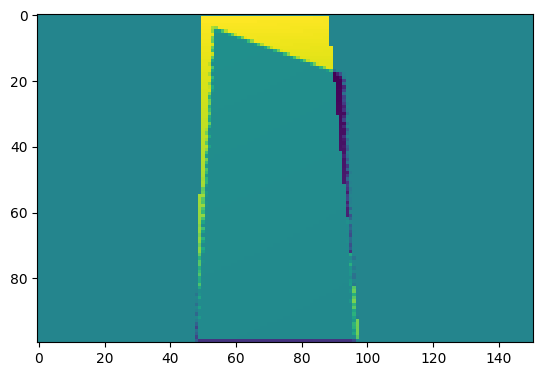

In [45]:
plt.imshow((torch.from_numpy(beam_plate2_gen)-beam_plate2_r)[48])

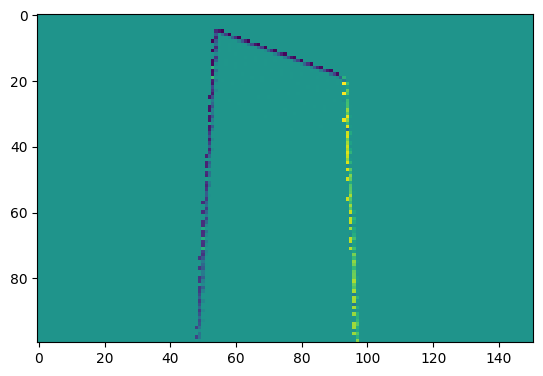

In [ ]:
# skimage rotate agrees with the rotate version
import skimage.transform
temp = skimage.transform.rotate(beam_plate2[48], 160, center=d.isocenter[1:])
plt.imshow(torch.from_numpy(temp)-beam_plate2_r[48])

In [61]:
ct_r.min()

tensor(-1086.9967, dtype=torch.float64)

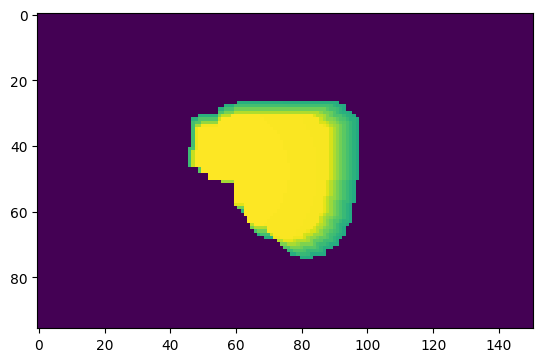

In [100]:
# BEV
bev = torch.from_numpy(beam_plate2).max(1)[0]
plt.imshow(bev)

In [83]:
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes

In [94]:
# Get a cylinder subvolume out
# for training the dose model
mask = bev!=0
mask.unsqueeze_(0) # Input needs to be [N, H, W]

x1, y1, x2, y2 = masks_to_boxes(mask)[0].int().tolist()
print(x1, x2, y1, y2)

46 97 27 74


In [102]:
subvol = beam_plate2[y1:y2, :, x1:x2]

In [103]:
subvol.shape

(47, 100, 51)

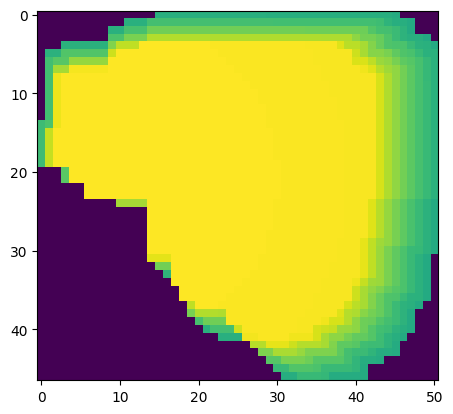

In [105]:
# BEV
bev_subvol = torch.from_numpy(subvol).max(1)[0]
plt.imshow(bev_subvol)

In [2]:
subvol.shape

NameError: name 'subvol' is not defined

In [8]:
get_source_from_angle(d.isocenter, d.angle_list[2], d.spacing)

(np.float64(48.0), -5, -437)